# Operations for basic photometry reduction using AutoPhOT


In [25]:
# Ignore this cell
import os
os.chdir('/Users/seanbrennan/anaconda2/envs/conda3/lib/python3.6/site-packages/')

In [26]:
import autophot

AutoPhOT requires input instructions
* Many of these are initial guesses and will be changed
* Need to load initial syntax

items in **bold** are parameters in the syntax dictionary that can be updated

In [27]:
# Load default input yaml file
from autophot.prep_input import load
syntax = load()

Default input loaded in from: 
/Users/seanbrennan/anaconda2/envs/conda3/lib/python3.6/site-packages/autophot/databases/default_input.yml


Current build of AutoPhOT works of local computer
(Future builds will be accessed via website)
* Can give directory of fits file via **fits_dir** or single file via **fname**.


In [28]:
# Built in function to move some example data onto the users desktop
from autophot.example import save_example_data
fpath = save_example_data.save_fits_to_desktop()

Successful copy of example.fits written to:
/Users/seanbrennan/Desktop/autophot_example/example.fits


Example fits file should now be available on desktop.

We can now tell AutoPhoT that we want to work on this file by updating **fname**.

Similiarly we can update **fits_dir** to */Users/*******/Desktop/autophot_example/* to perform autophot on all (fits,fit,fts) files in directory. AutoPhOT will ignore any files with template or wcs in the filename as these are used in template subtraction and astrometry.

In [29]:
syntax['fits_dir'] = None
syntax['fname'] = fpath

AutoPhOT accounts for unique keywords found in different headers

*telescope.yml* will be created and keeps track of different file naming conventions. This file is stored in **wdir**. 

We will set this to the same directory as example.fits.

In [30]:
import os
# get directory path
dirpath = os.path.dirname(fpath)

print('Setting work directory (wdir) to: %s' % dirpath)

# set working directory
syntax['wdir'] = dirpath

Setting work directory (wdir) to: /Users/seanbrennan/Desktop/autophot_example


Early version of code needs so additional parameters to get started

* Catalog version:
    * Currently available: Pan-STARRS, APASS, 2MASS and skymapper
    
* What transient you want to observe:
    * Enter either **target_name** to check TNS or **target_ra/target_dec** to observed specific source 
    
First we'll look at the example fits files using some packages from autophot

In [31]:
# Can choose skymapper, apass, pan_starrs, 2mass
syntax['catalog'] = 'skymapper'


/Users/seanbrennan/anaconda2/envs/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


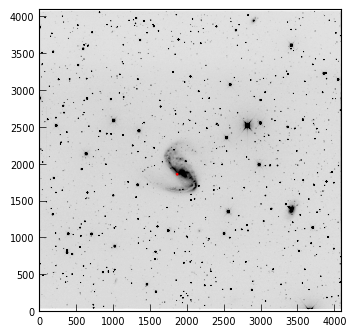

In [32]:
# autophot functions to find image data and header from fits files
from autophot.packages.functions import getimage
from autophot.packages.functions import getheader

# image
data = getimage(fpath)

# header
header = getheader(fpath)


# We will plot out the image 
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize,SquaredStretch,ZScaleInterval

# Create an ImageNormalize object
norm = ImageNormalize(stretch = SquaredStretch())
vmin,vmax = (ZScaleInterval(nsamples = 1000)).get_limits(data)

plt.imshow(data,
          vmin = vmin,
          vmax = vmax,
          norm = norm,
          origin = 'lower',
          cmap = 'Greys')

'''
For purpose of this example WCS is already in header. 
AutoPhOT is able to call astrometry.net from a local instance although for this example we assume the user doesn't
have astrometry installed
''' 
from astropy import wcs
w = wcs.WCS(header)

# Select a source - this source is not a transient although it is close to the center of the galaxy (NGC 2442)
ra = 114.070433
dec = -69.529716

# Choose a source in image
from astropy.coordinates import SkyCoord 
c = SkyCoord(ra,dec , unit="deg") 

x_pix,y_pix = w.all_world2pix(c.ra.degree, c.dec.degree, 1)

plt.scatter(x_pix,y_pix,marker = 'o',facecolor = 'none',edgecolor = 'r')

plt.show()

Need to tell AutoPhOT where to look. Target photometry has several options:

* **target_name** give the TNS IAU name ignore SN/AT e.g. SN 1987A => 1987A

* **target_ra**/**target_dec** give ra/dec (in ICRS) in degrees (all coords in AutoPhOT use degrees)

* leave both **target_name** and **target_ra**/**target_dec** blank (i.e. null \ None) to perform calibration on image (astrometry, fwhm, zeropint etc) only


we enter the source given its ra/dec. Checking SkyMapper catalog, source at 114.070433 -69.529716 has r =  17.401 +/- 0.01

In [33]:
print('Performing photometry on source at ra/dec = %.6f/%.6f' %  (c.ra.degree,c.dec.degree))

# in this case this source isn't in TNS so we leave target_name as None and update target_ra and target_dec
syntax['target_ra'] = c.ra.degree
syntax['target_dec'] = c.dec.degree

Performing photometry on source at ra/dec = 114.070433/-69.529716


Input is now ready to run!

For this demonstration, example.fits has trusted wcs already in the header. AutoPhOT will detect wcs keywords (CRVAL1, CRVAL2, etc) and skip over this step. If the user wants to force new astrometry, regardless of what is already written, set **remove_wcs** to True.

AutoPHoT relies on a user side dictionary of telescope data. Before starting, AutoPhOT will run through all files and ensure all keywords are known. It will ask the user to clariy any non-standard keywords. This may take away from the automation side of things but such steps only need to be taken once and it allows smoother operations if working with many files. For the purpose of this example there is no need in input scale_type or scale_units as we will not be needed astrometry.net so user can type *skip*. You'll see that if you rerun the script it won't ask you for this parameters as it check the pre-existing keys beforehand. For a more indepth example how telescope.yml works see [here](https://github.com/Astro-Sean/autophot/blob/master/example_call_database.ipynb)

This script (*write_yaml.yml*) is still underdevelopment as it needs to be be broad enough to accept various file structures and thusly, might fail. We hope to minimise these failures but as a backup, one can manually update the *telescope.yml* file.

To allow for a batch of files to be run, terminated and restarted from the same instance we have **restart** keyword that is defaulted to True. Leaving this command on will ignore any files that have already been ran through by the code. (i.e. it will look for the out.csv file in the output folders)

In [34]:
from autophot.autophot import run

run(syntax)

User instrument database: /Users/seanbrennan/Desktop/autophot_example/telescope.yml

Number of files: 1
1 telescope(s) detected - checking header keywords
Checking: EXAMPLE_TELESCOPE for unique keywords


Work on single file: /Users/seanbrennan/Desktop/autophot_example/example.fits

* Restarting - checking for files in /Users/seanbrennan/Desktop/autophot_example_REDUCED 


Total Files: 1 


Files already done: 0 


> Checking: Filters

Files removed - Wrong Image: 0


Files removed - No filter: 0


Files removed - Total: 0


+-------------+
| File: 1 / 1 |
+-------------+


File: example_APT.fits - PID: 25181
Start Time: 2020-06-15 11:57:05.291244
Telescope: EXAMPLE_TELESCOPE
Filter: r
Gain: 1
Exposure time: 60s 
Detecting/removing cosmic ray sources


Starting Astroscrappy ... working ... this may take some time ... done


Cosmic rays removed - image updated
WCS
WCS Values found
Number of sources before cleaning - [s = 200.0]: 337 
Isolated sources found [ 200.0 sigma ]: 164
FWHM (from all sources[164]): 4.649 
Aperture correction: -0.116 +/- 0.000
Searching for viable sources
New target name: target_ra_114.0_dec_-70.0
Catalog found for Target: target_ra_114.0_dec_-70.0
Catalog: SKYMAPPER 
File: target_ra_114.0_dec_-70.0_r_0.25
Catalog length: 1416


Matching catalog source to image: 239 / 877

Number of sources from catalog: 251


Matching catalog source to image: 251 / 877

Input data contains invalid values (NaNs or infs), which were automatically clipped.
Average pixel offset: 2.253 
Photometry
Using PSF Photometry
Limiting threshold: 5 sigma


Residual table updated: 5 / 6 

Image_radius [pix] : 8.213 +/- 0.175
FWHM of PSF model: 4.293
Approx PSF mag -7.471
Image cutout size: (14,14) (14,14)
Fitting PSF to 250 sources


Residual table updated: 6 / 6 


Zeropoint
zp_r: 22.866 +/- 0.033 < 


Limiting Magnitude
SNR limit cutoff: 5 - Mag error limit: 0.198
Approx. limiting magnitude: 18.087 
Target photometry on original image
Target Photometry
Fitting PSF to Target
Fitting PSF to 1 sources
Fitting gaussian to source to get FWHM
Target FWHM: 4.274


Fitting PSF to source: 1 / 1

Image 1 / 1 saved
SNR = 68 - checking limiting magnitude
Limiting threshold: 5 sigma
Number of pixels in star: 357


Mean: -1551.612 - std: 329.089
Detection at 5 std: 93.834
Target counts: 135.352 +/- 1.994
Target SNR: 67.865 +/- 0.016
Instrumental Magnitude: -5.329 +/- 0.016
Zeropoint: 22.866 +/- 0.033
Limiting Magnitude: 22.381
Target Magnitude: 17.537 +/- 0.045 
Time Taken [ 25181 ]: 142s
Sucess: example_APT - PID: 25181



---

Total failure : []

DONE
Recovering Output...
> Data Recovered <

Total Time Taken: 142s


Output of AutoPhOT will be given in folder in either parent directory of the file (if **fname** is defined) or the parent dictionary of the fits_folder (if **fits_dir** is defined), below we display some of the visual outputs

AutoPhOT has automated PSF buillding and fitting feature - below is the target subtraction

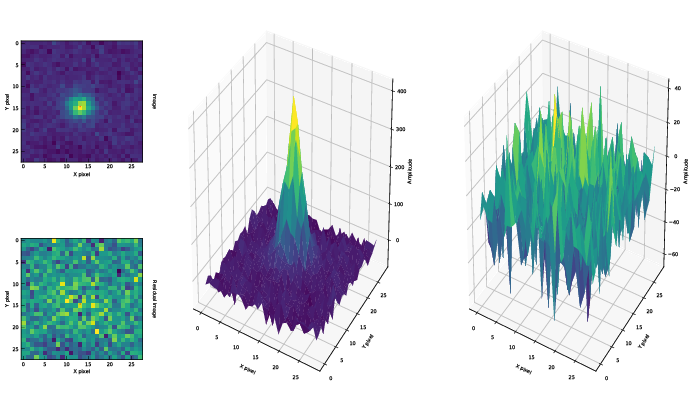

In [35]:
# Wand is used to display pdf images in jupyter notebooks - it is not needed for AutoPhoT
from wand.image import Image as WImage
PSF = WImage(filename = "/Users/seanbrennan/Desktop/autophot_example/example/target_psf_example_APT.pdf",
             resolution = 50)
PSF

Zeropint calibration from skymapper with some gentle sigma clipping

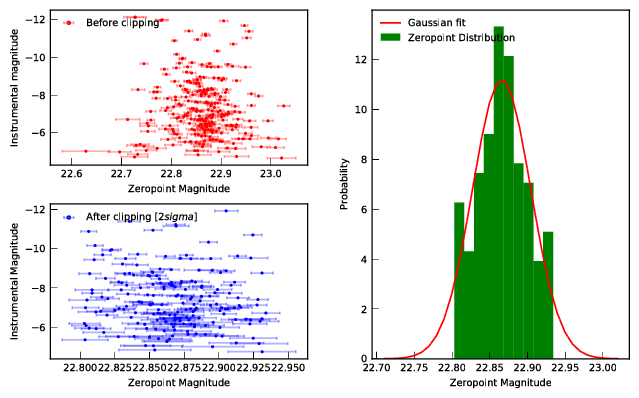

In [39]:
ZP = WImage(filename = "/Users/seanbrennan/Desktop/autophot_example/example/zp_example_APT.pdf",
            resolution = 100)
ZP

Magnitude recovery from PSF fitting in comparision to values from skymapper. We see the magnitude from the catalog minus the magnitude from the PSF fitting is fitted well

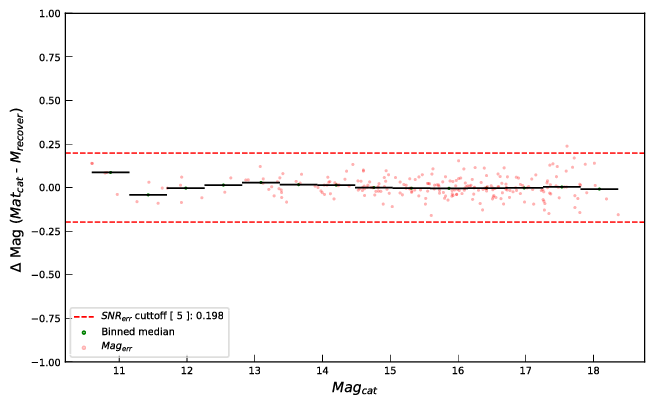

In [41]:
MAG_LIM= WImage(filename = "/Users/seanbrennan/Desktop/autophot_example/example/mag_lim_example_APT.pdf",
                resolution = 100)
MAG_LIM

Output image showing stars using for zeropoint (blue), PSF stars (Yellow) and tagrget (green)

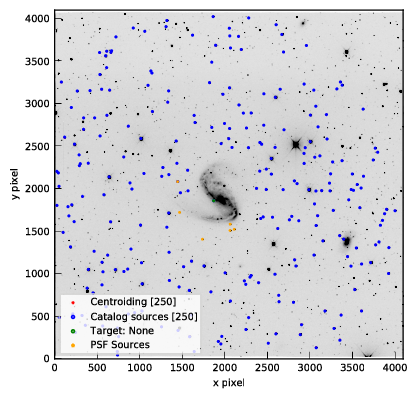

In [38]:
SOURCE_CHECK= WImage(filename = "/Users/seanbrennan/Desktop/autophot_example/example/source_check_example_APT.pdf",
                     resolution = 100)
SOURCE_CHECK